In [1]:
# those variables will be updated by Mercury framework
# let's keep all variables to be updated in one cell
stadsdeel = 'Centrum'

# <center> Amsterdam on charts and maps (2021 year) </center>

<-- (on the left panel) you can choose Amsterdam district want to see charts about.

In [2]:
#pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import geopandas as gpd
import shapely
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown as Markdown, display
from branca.colormap import linear
import seaborn as sns

geo_data = pd.read_csv("geodata_amsterdam.csv")
geo_data['geometry'] = geo_data['geometry'].apply(lambda x: shapely.wkt.loads(x))  

In [4]:
data_map = pd.read_csv('amsterdam_buurten.csv')
data_district = pd.read_csv('amsterdam_district.csv')
data_prijs = pd.read_csv('woning_prijs.csv')

In [5]:

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

main_color = colors[6]
second_color = colors[0]
index_stadsdeel = data_district.loc[data_district['stadsdeel'] == stadsdeel].index[0]
colors_selected = [second_color,] * 9
colors_selected[index_stadsdeel] = main_color

import circlify

def show_bedrijven_by_industry_charts(row_district):
    value_map = {'Industry \n and Energy': 100*row_district['aantal_bedrijven_nijverheid_energie']/row_district['aantal_bedrijfsvestigingen'],
                'Trade and Hospitality': 100*row_district['aantal_bedrijven_handel_en_horeca']/row_district['aantal_bedrijfsvestigingen'],
                'Transport, IT \n and communication':100*row_district['aantal_bedrijven_vervoer_informatie_communicatie']/row_district['aantal_bedrijfsvestigingen'],
                'Financial Services, \n Real Estate':100*row_district['aantal_bedrijven_financieel_onroerend_goed']/row_district['aantal_bedrijfsvestigingen'],
                'Business services':100*row_district['aantal_bedrijven_zakelijke_dienstverlening']/row_district['aantal_bedrijfsvestigingen'],
                'Government, \n education, \n healthcare':100*row_district['aantal_bedrijven_overheid_onderwijs_en_zorg']/row_district['aantal_bedrijfsvestigingen'],
                'Culture,  \n recreation, \n other services':100*row_district['aantal_bedrijven_cultuur_recreatie_overige']/row_district['aantal_bedrijfsvestigingen']
                }
                                                                                                                                         
    sorted_values = sorted(value_map.items(), key=lambda x:x[1] , reverse=True)
        
    labels = []
    values = []
    
    for label, value in sorted_values:
        labels.append(label)
        values.append(value)
    
    # create a circles chart, code copy-pasted from this article: https://towardsdatascience.com/9-visualizations-to-show-proportions-or-percentages-instead-of-a-pie-chart-4e8d81617451
    # compute circle positions:
    circles = circlify.circlify(values, 
                                show_enclosure=False, 
                                target_enclosure=circlify.Circle(x=0, y=0)
                               )
    circles.reverse()
    
    #create a laebls list for each bubble 
    label = ['{} \n {:.1f}%'.format(label, value) for label,value in zip(labels,
                                                                values)]
    fig, ax = plt.subplots(figsize=(14,14), facecolor='white')
    ax.axis('off')
    lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r,) for circle in circles)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    
    # print circles
    for circle, note, color in zip(circles, label, colors[:7]):
        x, y, r = circle
        ax.add_patch(plt.Circle((x, y), r, alpha=1, color = color))
        plt.annotate(note.replace('<br>','\n'), (x,y), size=16, va='center', ha='center')

    plt.xticks([])
    plt.yticks([])
    plt.show()


In [6]:
def show_all_bedrijven_charts(row_district):

    value_amster = data_district['aantal_bedrijfsvestigingen'].sum()
    value_stadsdeel = row_district['aantal_bedrijfsvestigingen']
    value_persentage = value_stadsdeel * 100 /value_amster
    display(Markdown("### There are {:.1f}% of Amsterdam businesses located in {}".format(value_persentage, stadsdeel)))
    
    df = data_district.copy()
    df['Y'] = [1]*len(df)
    list_x = list(range(0,len(df)))
    df['X'] = list_x
    
    #create a labels list for each bubble 
    label = ["{} <br> {:.1f}%".format(district, 100*companies/value_amster) for district, companies in zip(df.stadsdeel,
                                          df.aantal_bedrijfsvestigingen)]
    
    fig = px.scatter(df, x='X', y='Y',
                     color='stadsdeel', 
                     color_discrete_sequence=colors_selected,
                     size='aantal_bedrijfsvestigingen', 
                     text=label, 
                     size_max=90
                    )
    fig.update_layout(
                      margin = dict(t=70, l=0, r=0, b=0),
                      showlegend=False
                     )
    fig.update_traces(textposition='top center')
    fig.update_xaxes(showgrid=False, zeroline=False, visible=False)
    fig.update_yaxes(showgrid=False, zeroline=False, visible=False)
    fig.update_layout({'plot_bgcolor': 'white', 'paper_bgcolor': 'white'})
    fig.show()


In [7]:
def show_housing_charts(row_district):
   
    value_amster = data_district['woningvoorraad'].sum()
    value_stadsdeel = row_district['woningvoorraad']
    value_persentage = value_stadsdeel * 100 / value_amster
    display(Markdown("#### There are {:.1f}% of Amsterdam houses located in {}".format(value_persentage, stadsdeel)))    


    #create a list of percentages for labeling
    label = ['{}: {:.0f}'.format(label, value) for label,value in zip(data_district.stadsdeel, data_district.woningvoorraad)]
    
    color_map = dict(zip(data_district.stadsdeel.tolist(),colors_selected))
    fig = px.treemap(data_district, path=[px.Constant('Number of houses in Amsterdam'), 'stadsdeel'],
                 values = data_district.woningvoorraad,
                 color = data_district.stadsdeel,
                 color_discrete_map = color_map,
                 hover_name = label,
                )
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25), showlegend=True)
    fig.show()
    
    
    #Charts about house prices
    specs = [[{"type": "bar"}, {"type": "bar"}]]
    index_stadsdeel = data_prijs.loc[data_prijs['stadsdeel'] == stadsdeel].index[0]
    colors_prijs = [second_color,] * 9
    colors_prijs[index_stadsdeel] = main_color
    
    years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
    fig = make_subplots(rows=1, cols=2, specs = specs, shared_yaxes = True, subplot_titles=['in 2021 among districts','House prices in 2015-2021'])
    
    fig.add_trace(go.Bar(
        x = data_prijs['stadsdeel'],
        y = data_prijs['2021'],
        marker_color = colors_prijs), 1, 1)  
    
    index = 0
    for district in data_prijs['stadsdeel']:
        values = data_prijs.loc[data_prijs['stadsdeel'] == district, years].values.flatten().tolist()
        width = 10 if district == stadsdeel else 4
        fig.add_trace(go.Scatter(x = years, 
                                 y = values,
                                 mode = 'lines',
                                 name = district,
                                 line = dict(color=colors[index], width = width)), 1, 2)
        index = index + 1

    fig.update_layout(showlegend = True, title=dict(text="Average house price in " + stadsdeel + " district", 
                                                    font=dict(family="Arial", size=20, color='#283747')))  
    fig.show()
    
    bouwjaarklasse_tot_2000 = row_district['bouwjaarklasse_tot_2000']
    bouwjaarklasse_vanaf_2000 = row_district['bouwjaarklasse_vanaf_2000']
    
    value_koop = row_district['koopwoningen']
    value_huur = row_district['huurwoningen']
    value_onbekend = row_district['woningen_met_eigendom_onbekend']
    woningcorporaties = row_district['huurwoningen_in_bezit_woningcorporaties']
    overige_verhuurders = row_district['huurwoningen_in_bezit_overige_verhuurders']
    
    specs = [[{'type':'pie'}, {"type": "pie"}]]
    
    fig = make_subplots(rows=1, cols=2, specs = specs, shared_yaxes = True, subplot_titles=['','Houses built'])
    
    fig.add_trace(go.Pie(labels = ['Single-family','Multi-family'], values = [row_district['eengezinswoning'], row_district['meergezinswoning']], marker_colors=[main_color, second_color]), 1, 1)  
    fig.add_trace(go.Pie(labels = ['before 2000','after 2000'], values = [bouwjaarklasse_tot_2000,bouwjaarklasse_vanaf_2000], marker_colors=[main_color, second_color]), 1, 2)  
    fig.update_traces(textinfo='label + percent')
    fig.update_layout(showlegend = False, title=dict(text="Houses characteristics", font=dict(family="Arial", size=20, color='#283747')))  
    fig.show()
    
    
    specs = [[{'type':'bar'}, {"type": "bar"}]]
    
    fig = make_subplots(rows=1, cols=2, specs = specs, shared_yaxes = True, subplot_titles=['Occupation','Owned by'])
    
    #fig.add_trace(go.Pie(labels = ['owner-occupied','rental'], values = [value_koop, value_huur], marker_colors=colors), 2, 1)  
    fig.add_trace(go.Bar(
        y = ['owner-occupied'],
        x = [value_koop],
        name='owner-occupied',
        orientation='h',
        textposition='inside',
        text=['owner-occupied'],
        marker=dict(color=main_color, line = dict(color = main_color, width=3))), 1, 1)
    
    fig.add_trace(go.Bar(
        y=['rental'],
        x=[value_huur],
        name='rental',
        orientation='h',
        textposition='inside',
        text=['rental'],
        marker=dict(color=second_color, line = dict(color = second_color, width=3))), 1, 1)
    
    fig.update_layout(barmode='stack')
    
    #fig.add_trace(go.Pie(labels = ['housing association','other landlords', 'ownership unknown'], values = [woningcorporaties, overige_verhuurders, value_onbekend], marker_colors=colors), 2, 2)  
    fig.add_trace(go.Bar(
        y = ['housing association'],
        x = [woningcorporaties],
        name='housing association',
        orientation='h',
        textposition='inside',
        text=['housing association'],
        marker=dict(color=main_color, line = dict(color = main_color, width=3))), 1, 2)
    
    fig.add_trace(go.Bar(
        y=['other landlords'],
        x=[overige_verhuurders],
        name='other landlords',
        orientation='h',
        textposition='inside',
        text=['other landlords'],
        marker=dict(color=second_color, line = dict(color = second_color, width=3))), 1, 2)
    fig.add_trace(go.Bar(
        y=['ownership unknown'],
        x=[value_onbekend],
        name='rental',
        orientation='h',
        textposition='outside',
        text=['ownership unknown'],
        marker=dict(color=colors[4], line = dict(color = colors[4], width=3))), 1, 2)
    
    fig.update_yaxes(visible=False, showticklabels=False)

    fig.update_layout(barmode='stack')
    
    fig.update_layout(showlegend = False, title=dict(text="Houses characteristics", font=dict(family="Arial", size=20, color='#283747')))  
    fig.show()
    
    
    

In [8]:
def show_amenities(row_district):
  
    value_huisarts = row_district['huisartsenpraktijk_avg_km']
    value_apotheek = row_district['apotheek_avg_km']
    value_grote_supermarkt = row_district['grote_supermarkt_avg_km']
    value_winkels_ov_dagelijkse = row_district['winkels_ov_dagelijkse_avg_km']
    value_cafe = row_district['cafe_avg_km']
    value_cafetaria = row_district['cafetaria_avg_km']
    value_restaurant = row_district['restaurant_avg_km']
    
    labels = ['GP practice', 'Pharmacy', 'Large supermarket', 'Daily groceries', 'Cafe', 'Cafeteria', 'Restaurant']
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x = labels,
        y = [value_huisarts, value_apotheek, value_grote_supermarkt, value_winkels_ov_dagelijkse, value_cafe, value_cafetaria,
            value_restaurant],
    marker_color=colors))
    
    fig.update_traces(texttemplate='%{y:.1f}')
    fig.update_layout(xaxis_tickangle=-45,
                 title_text='Average distance to daily life amenities (in km)')#uniformtext_minsize=8, uniformtext_mode='hide', 
    fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total ascending'})
    fig.show()
   
    value_kinderdagverblijf = row_district['kinderdagverblijf_avg_km']
    value_bso = row_district['bso_avg_km']
    value_basisonderwijs = row_district['basisonderwijs_avg_km']
    value_voortgezet = row_district['voortgezet_onderwijs_avg_km']
    value_vmbo = row_district['vmbo_gemiddelde_avg_km']
    value_havo_vwo = row_district['havo_vwo_avg_km']
    
    labels = ['Daycare', 'After school care', 'Primary schools', 'Secondary school', 'Pre-vocational secondary education', 
              'High education']
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x = labels,
        y = [value_kinderdagverblijf, value_bso, value_basisonderwijs, value_voortgezet, value_vmbo, value_havo_vwo],
        marker_color=colors))
    
    fig.update_traces(texttemplate='%{y:.1f}')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45,
                 title_text='Average distance to education (in km)')
    fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total ascending'})
    fig.show()
    
    labels = ['Hotel', 'Fire station', 'Swimming pool', 'Artificial ice skating rink', 'Library', 'Cinema', 
              'Sauna', 'Tanning bed', 'Attraction']
    value_sauna = row_district['sauna_avg_km']
    value_zonnebank = row_district['zonnebank_avg_km']
    value_attractiepark = row_district['attractiepark_avg_km']
    value_hotel = row_district['hotel_avg_km']
    value_brandweerkazerne = row_district['brandweerkazerne_avg_km']
    value_zwembad = row_district['zwembad_avg_km']
    value_kunstijsbaan = row_district['kunstijsbaan_avg_km']
    value_bibliotheek = row_district['bibliotheek_avg_km']
    value_bioscoop = row_district['bioscoop_avg_km']
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x = labels,
        y = [value_hotel, value_brandweerkazerne, value_zwembad, value_kunstijsbaan, value_bibliotheek, value_bioscoop, 
            value_sauna, value_zonnebank, value_attractiepark],
    marker_color=colors))
    fig.update_traces(texttemplate='%{y:.1f}')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45,
                 title_text='Average distance to other amenities (in km)')
    fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total ascending'})
    fig.show()
    

In [9]:
def style_fn(feature):
    ss = {
        "fillColor": colors[5],
        "fillOpacity": 0.9,
        "weight": 0.9,
        "opacity": 1,
        "color": "black",
    }
    return ss

def show_district_map(row_district):
    #Amsterdam
    latitude = 52.377956
    longitude = 4.8970
    
    # create map and display it
    m = folium.Map(location=[latitude, longitude], 
                   zoom_start=12)#, tiles='CartoDB positron')
    
    
    buurtcoden = data_map[data_map['stadsdeel'] == stadsdeel]['buurtcode'].unique()
    new_geodata = geo_data[geo_data['buurtcode'].isin(buurtcoden)]
    
    new_geodata = new_geodata.copy()
    
    gdf = gpd.GeoDataFrame(data=new_geodata, geometry=new_geodata['geometry'], crs=4329)
    
    folium.GeoJson(
        gdf.__geo_interface__,
        style_function=style_fn
    ).add_to(m)
    
    display(Markdown("# {}  on the map".format(stadsdeel)))

    # show map
    display(m)

## <center>Business</center>

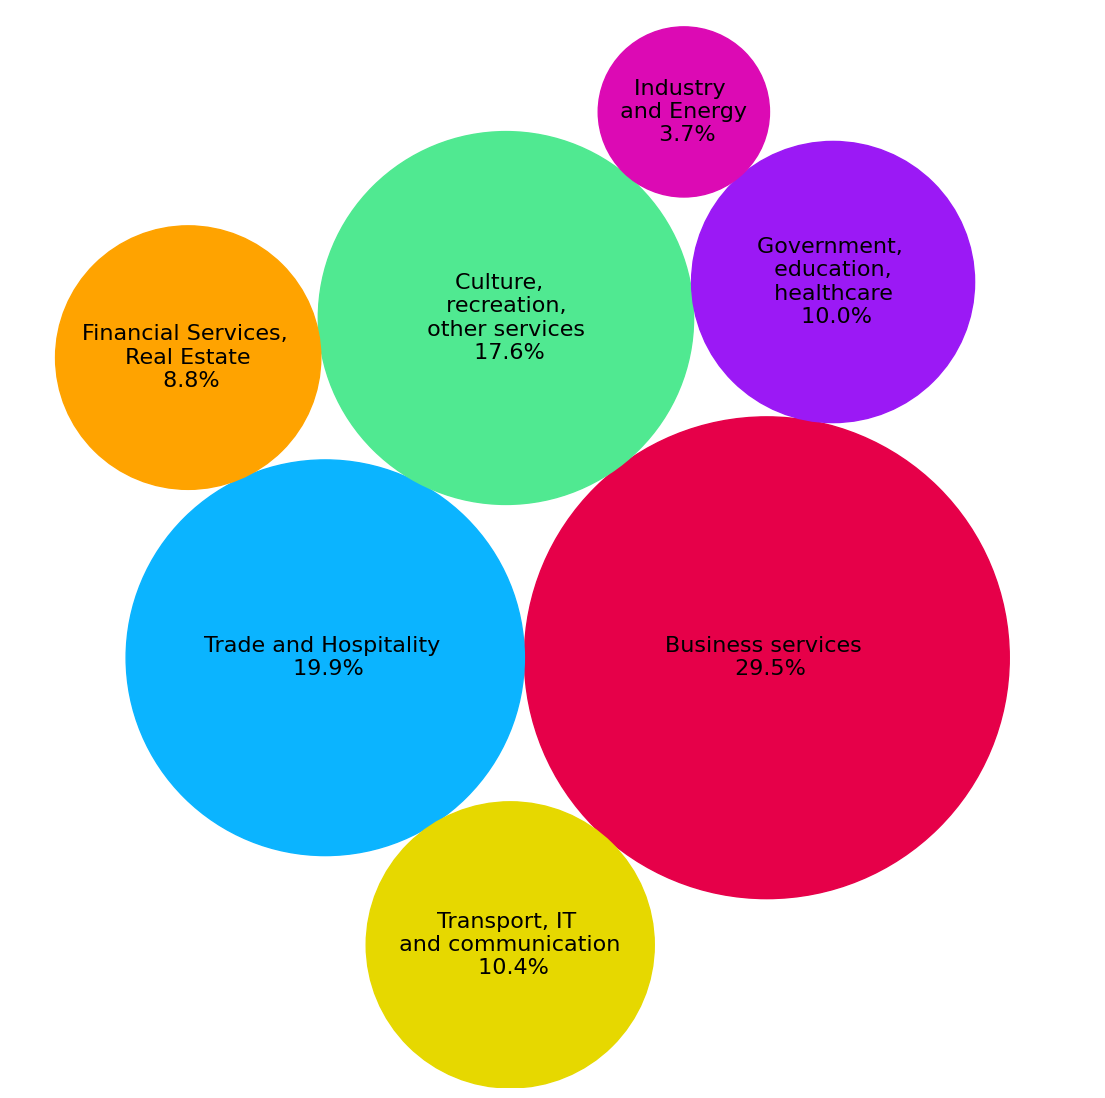

### There are 18.1% of Amsterdam businesses located in Centrum

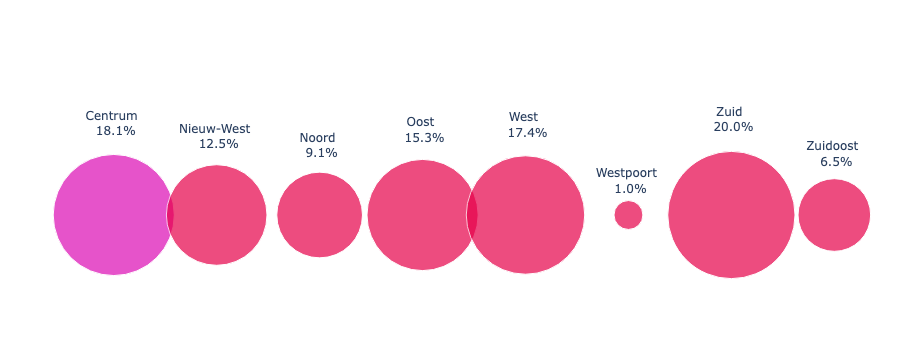

## <center>Housing</center>

#### There are 12.2% of Amsterdam houses located in Centrum

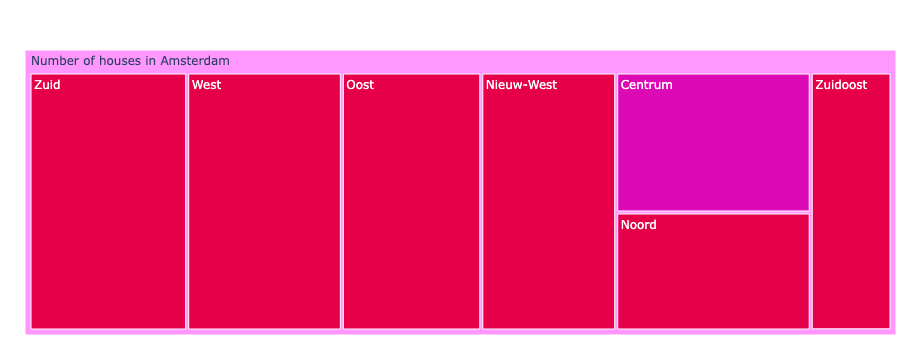

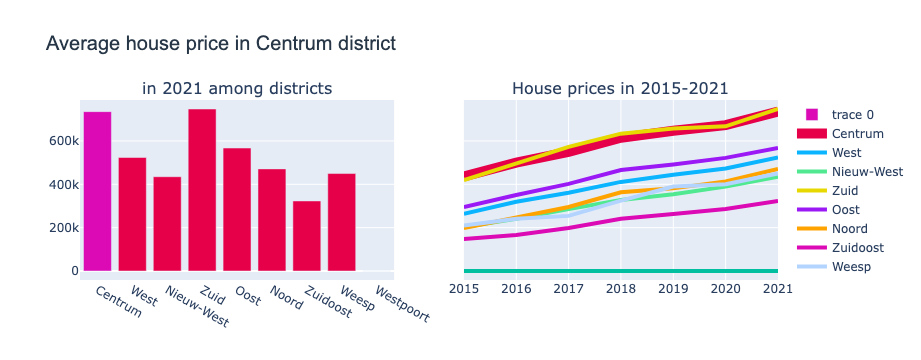

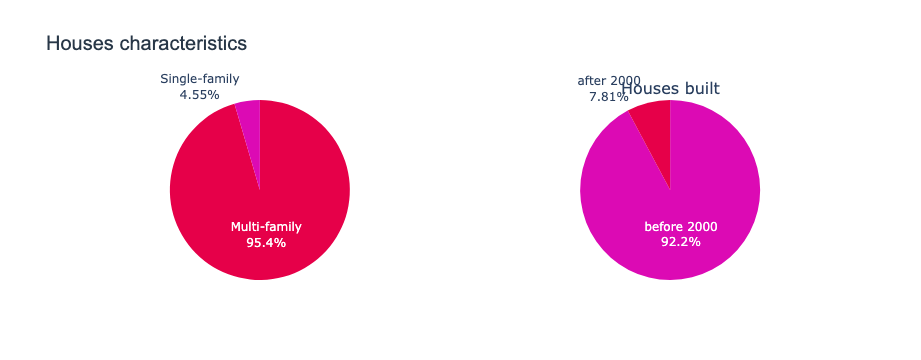

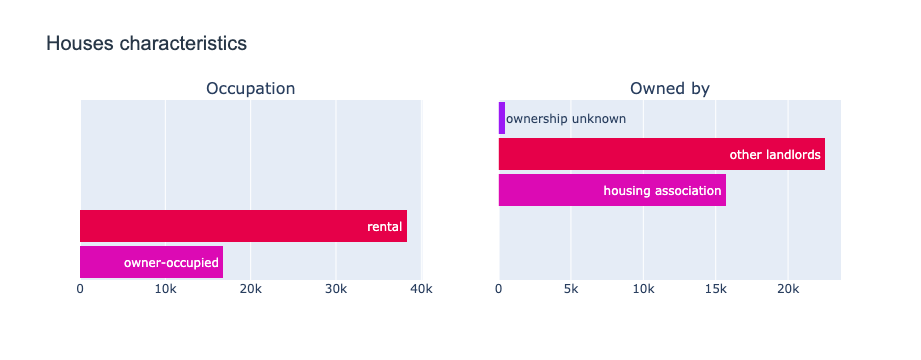

## <center>Amenities</center>

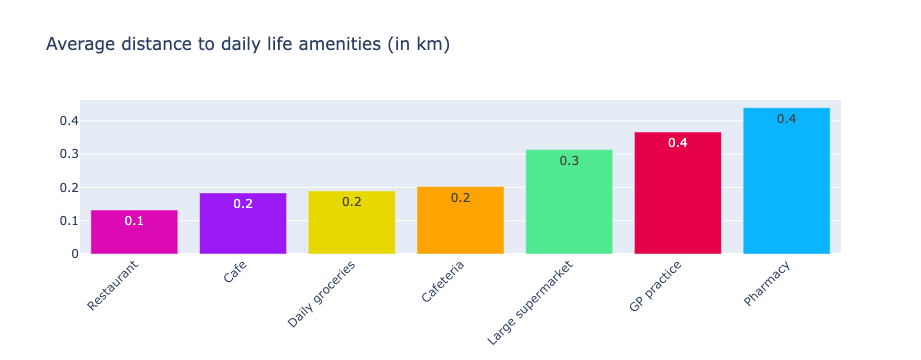

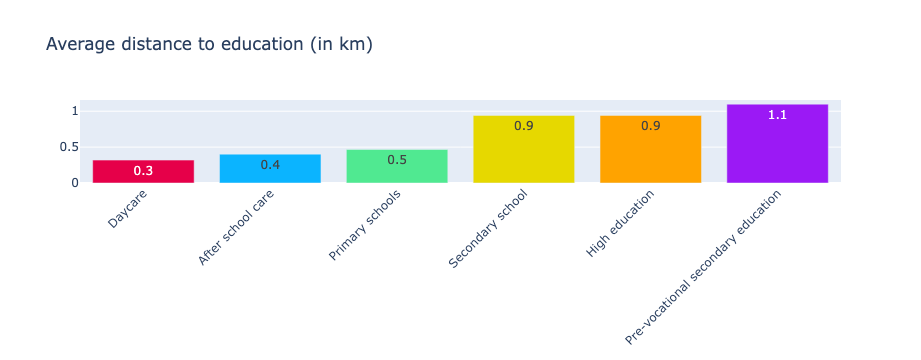

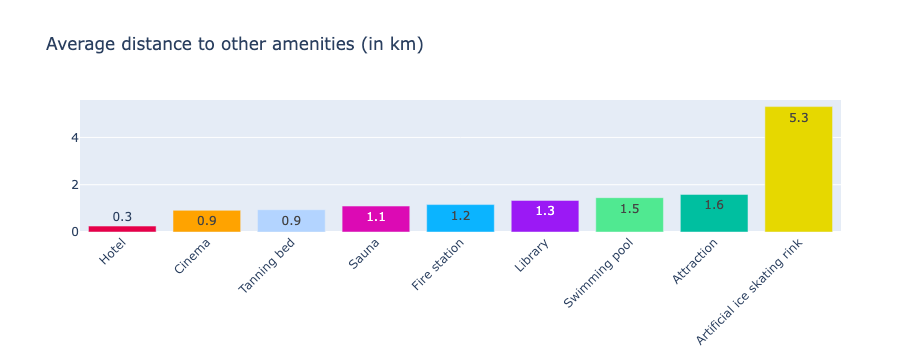

# Centrum  on the map

In [10]:
row_district = data_district.loc[data_district['stadsdeel'] == stadsdeel].iloc[0]
display(Markdown("## <center>Business</center>"))
show_bedrijven_by_industry_charts(row_district)
show_all_bedrijven_charts(row_district)
display(Markdown("## <center>Housing</center>"))
show_housing_charts(row_district)
display(Markdown("## <center>Amenities</center>"))
show_amenities(row_district)
show_district_map(row_district)

In [11]:
#data.columns.to_list()